## FINE-TUNE DistilBERT on a Sentiment Classification Task (IMDB Dataset )

## Install and import necessary libraries 

In [1]:
! pip install transformers

     |████████████████████████████████| 3.5 MB 5.3 MB/s 
     |████████████████████████████████| 67 kB 5.2 MB/s 
     |████████████████████████████████| 596 kB 40.1 MB/s 
     |████████████████████████████████| 6.8 MB 43.6 MB/s 
     |████████████████████████████████| 895 kB 46.0 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [2]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification, Trainer, TrainingArguments
import torch


## Chech for GPU

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device available for running: ")
print(device)

Device available for running: 
cuda


In [4]:
# Define pretrained tokenizer and model

model_checkpoint = "distilbert-base-uncased"

tokenizer = DistilBertTokenizerFast.from_pretrained(model_checkpoint)

model = DistilBertForSequenceClassification.from_pretrained(model_checkpoint, num_labels=2)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/256M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'classifier.weight', 'pre_classi

## Preprocess data

In [5]:
# Read data
data_train = pd.read_csv("/content/data_train.csv")
data_dev = pd.read_csv("/content/data_dev.csv")
data_test = pd.read_csv("/content/data_test.csv")

train_labels = data_train['sentiment'].tolist()
train_texts = data_train['review'].tolist()
val_labels = data_dev['sentiment'].tolist()
val_texts = data_dev['review'].tolist()
test_labels = data_test['sentiment'].tolist()
test_texts = data_test['review'].tolist()

In [6]:
# Apply Tokenizer

train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings = tokenizer(val_texts, truncation=True, padding=True)
test_encodings = tokenizer(test_texts, truncation=True, padding=True)

In [7]:
# Create torch dataset

class IMDbDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [8]:
train_dataset = IMDbDataset(train_encodings, train_labels)
val_dataset = IMDbDataset(val_encodings, val_labels)
test_dataset = IMDbDataset(test_encodings, test_labels)

In [9]:
# Helper Function

def compute_metrics(p):
    pred, labels = p
    pred = np.argmax(pred, axis=1)

    accuracy = accuracy_score(y_true=labels, y_pred=pred)
    recall = recall_score(y_true=labels, y_pred=pred)
    precision = precision_score(y_true=labels, y_pred=pred)
    f1 = f1_score(y_true=labels, y_pred=pred)

    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}


## Fine-tune model

In [10]:
# Folder name which will be used to save the checkpoints of the model
model_name = model_checkpoint.split("/")[-1]

# Define all attributes to customize the training
args = TrainingArguments(
    f"/content/{model_name}-finetuned-imdb",
    evaluation_strategy="epoch",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    seed=0,
    weight_decay=0.01,
    save_strategy= "epoch",
    load_best_model_at_end=True)

In [11]:
# Instantiate a Trainer objects and pass all needed arguments 

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics)

In [12]:
# model training (finetuning)
trainer.train()


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 40999
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 15375


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.265900,0.213746,0.924444,0.900924,0.953778,0.926598
2,0.172400,0.348763,0.923556,0.956855,0.887111,0.920664
3,0.048700,0.363890,0.930667,0.926496,0.935556,0.931004


***** Running Evaluation *****
  Num examples = 4500
  Batch size = 8
Saving model checkpoint to /content/distilbert-base-uncased-finetuned-imdb/checkpoint-5125
Configuration saved in /content/distilbert-base-uncased-finetuned-imdb/checkpoint-5125/config.json
Model weights saved in /content/distilbert-base-uncased-finetuned-imdb/checkpoint-5125/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 4500
  Batch size = 8
Saving model checkpoint to /content/distilbert-base-uncased-finetuned-imdb/checkpoint-10250
Configuration saved in /content/distilbert-base-uncased-finetuned-imdb/checkpoint-10250/config.json
Model weights saved in /content/distilbert-base-uncased-finetuned-imdb/checkpoint-10250/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 4500
  Batch size = 8
Saving model checkpoint to /content/distilbert-base-uncased-finetuned-imdb/checkpoint-15375
Configuration saved in /content/distilbert-base-uncased-finetuned-imdb/checkpoint-15375/config.json
Model

TrainOutput(global_step=15375, training_loss=0.18001549263310626, metrics={'train_runtime': 11497.5785, 'train_samples_per_second': 10.698, 'train_steps_per_second': 1.337, 'total_flos': 1.6293092632492032e+16, 'train_loss': 0.18001549263310626, 'epoch': 3.0})

## Evaluate

In [13]:
# Load trained model

model_path = "/content/distilbert-base-uncased-finetuned-imdb/checkpoint-5125"
model = DistilBertForSequenceClassification.from_pretrained(model_path, num_labels=2)

loading configuration file /content/distilbert-base-uncased-finetuned-imdb/checkpoint-5125/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "problem_type": "single_label_classification",
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "torch_dtype": "float32",
  "transformers_version": "4.16.2",
  "vocab_size": 30522
}

loading weights file /content/distilbert-base-uncased-finetuned-imdb/checkpoint-5125/pytorch_model.bin
All model checkpoint weights were used when initializing DistilBertForSequenceClassification.

All the weights of DistilBertForSequenceClassificatio

In [14]:
# Define test trainer
test_trainer = Trainer(model)

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [15]:
# Make prediction
raw_pred, _, _ = test_trainer.predict(test_dataset)

***** Running Prediction *****
  Num examples = 4501
  Batch size = 8


In [20]:
# Preprocess raw predictions
y_pred = np.argmax(raw_pred, axis=1)
y_pred = y_pred.tolist()


In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import metrics


best

                  precision    recall  f1-score   support

class 0_negative       0.94      0.91      0.92      2250
class 1_positive       0.91      0.94      0.92      2251

        accuracy                           0.92      4501
       macro avg       0.92      0.92      0.92      4501
    weighted avg       0.92      0.92      0.92      4501



Text(91.68, 0.5, 'predicted label')

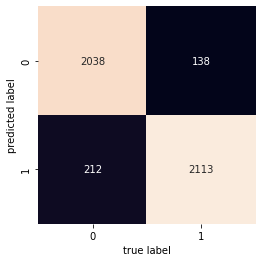

In [22]:
# metrics report
target_names = ['class 0_negative', 'class 1_positive']
scores = metrics.classification_report(test_labels, y_pred, target_names=target_names)
print('best\n')
print(scores)
mat = confusion_matrix(test_labels, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label')